In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
from preprocess.sza import solarzenithangle
from utils.etc import benchmark
from dask.distributed import Client
import shutil, gc
import os

In [2]:
client = Client(n_workers=12)

In [3]:
stations = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
stations.station_id.values

array([ 3287,   891,  3231,  3023,  3631,  1691,  2261,  3946,  5792,
         963,  5516,  4336,  1612,  3987,  3015,  4911,   701,  5839,
        2485,   232,  4745,  1757,  1078,  1957,   722,   282, 15444,
        3126,   867,  7351,   656,  3513,  1684,  5142,  6163,  4928,
        7369,  4466,  2638,  2483,  3158,  2290,  5404,   222,  3196,
         853,  3032,  1580,  4347,  2925,  1605,  3366,  1766,  7370,
        2044,  7368, 15000,  1270,  5906,  2014,  5009,  5779,  2522,
         953,  3761,  5397,  2667,  4104,  1001,  2171,   430,   460,
         183,  3660,   554,   596,  1503,  1346,  5100,   662,  4177,
        5705,  1443,  7374,  5467,  3668,  1468,  6197,  2559,  7244,
         198,  1420, 13674,  1544,  3086,  2115,  5426,  5629,  5155,
         342,  4024,  1358,  4642,  1550,  3098,   880,  4887,   591,
        5490,  7367,  2907,  1869,  3268,  1639,   427,   856,  3028,
        5546,  2601,   704,  1975,  1048,  2932,   840,  3167,   164,
        5440,   298,

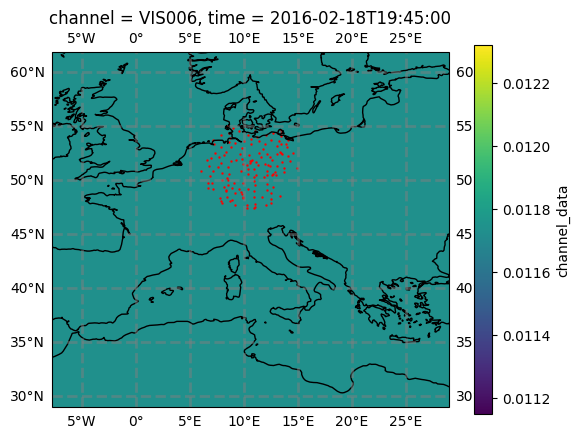

In [4]:
hrseviri = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SEVIRI_new.zarr')

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.lat.values
lon = stations.lon.values
name = stations.name.values
axis.scatter(x=lon, y=lat, c='r', s=.5)
# for i, txt in enumerate(name):
#     axis.annotate(txt, (lon[i], lat[i]))

hrseviri.channel_data.sel(channel='VIS006').isel(time = 2000).plot.imshow(ax=axis, transform = proj)



In [9]:


def create_collocated_zarr_dwd(hrseviri, station_id, patch_size=31):
    
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_10min_{str(station_id).zfill(5)}.nc')

    lat = station.lat.values
    lon = station.lon.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station['time'] = station.time - np.timedelta64(10, 'm')

    intersec = set(station.time.values).intersection(hrseviri.time.values)

    if len(intersec)< 1000:
        print(f'skipping station, too little points {station_id}')
        return None


    hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()
    for var in hres_slice:
        hres_slice[var].encoding.clear()

    with benchmark('temp2'):
        hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
        temp = xarray.open_zarr('temp2.zarr')

    hres_slice = temp.where(temp.time.isin(station.time), drop=True).drop_duplicates(dim='time')
    _, index = np.unique(hres_slice['time'], return_index=True)
    subset_station = station.isel(time=index)

    hres_slice['GHI'] = ('time', (subset_station.GS_10.data/(10*60))*10000)# J/cm2 per 10 min to watt/m2
    
    hres_slice['DIF'] = ('time', (subset_station.DS_10.data/(10*60))*10000)
    hres_slice['station_name'] = str(subset_station.station_name.values)
    hres_slice['lat_station'] = subset_station.lat.data
    hres_slice['lon_station'] = subset_station.lon.data
    hres_slice['altitude_station'] = subset_station.elevation.data

    with benchmark('SZA'):
        SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                    hres_slice.lat_station.values, 
                                    hres_slice.lon_station.values, 
                                    hres_slice.altitude_station.values)

    hres_slice['SZA'] = ('time', SZA.astype(np.float32))
    hres_slice['AZI'] = ('time', AZI.astype(np.float32))

    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()

    hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
    hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

    with benchmark('zarr'):
        hres_slice.to_zarr(SAVE_PATH + f'DWD_SOLAR_{str(station_id).zfill(5)}.zarr', mode='w')
    
    print()
    print(f'        STATION {station_id} DONE         ')
    print()

def create_collocated_zarr_knmi(hrseviri, station_id, patch_size=31):
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')
    
    lat = station.lat.values
    lon = station.lon.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station['time'] = station.time - np.timedelta64(10, 'm')

    intersec = set(station.time.values).intersection(hrseviri.time.values)

    if len(intersec)< 1000:
        print(f'skipping station, too little points {station_id}')
        return None


    hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()
    for var in hres_slice:
        hres_slice[var].encoding.clear()

    with benchmark('temp2'):
        hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
        temp = xarray.open_zarr('temp2.zarr')

    hres_slice = temp.where(temp.time.isin(station.time), drop=True).drop_duplicates(dim='time')
    _, index = np.unique(hres_slice['time'], return_index=True)
    subset_station = station.isel(time=index)

    
    hres_slice['GHI'] = ('time', subset_station.Q_GLOB_10.data)
    hres_slice['GHI_min'] = ('time', subset_station.QN_GLOB_10.data)
    hres_slice['GHI_max'] = ('time', subset_station.QX_GLOB_10.data)
    hres_slice['station_name'] = str(station_id)
    hres_slice['lat_station'] = subset_station.lat.data
    hres_slice['lon_station'] = subset_station.lon.data
    hres_slice['altitude_station'] = subset_station.altitude.data
    
    with benchmark('SZA'):
        SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                    hres_slice.lat_station.values, 
                                    hres_slice.lon_station.values, 
                                    hres_slice.altitude_station.values)

    hres_slice['SZA'] = ('time', SZA.astype(np.float32))
    hres_slice['AZI'] = ('time', AZI.astype(np.float32))

    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()

    hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
    hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

    with benchmark('zarr'):
        hres_slice.to_zarr(SAVE_PATH + f'KNMI_SOLAR_{str(station_id)}.zarr', mode='w')
    
    print()
    print(f'        STATION {station_id} DONE         ')
    print()
    
    
import shutil
import gc

def rechunk_zarr_store(zarr, chunks, target_zarr):
    slice_lengths = int(len(zarr.time) / 250)
    # temp = xarray.open_zarr(target_zarr)
    already_rechunked =0
    # temp.close()
    for i in tqdm(range(0, len(zarr.time), slice_lengths)):
        if i + slice_lengths <= already_rechunked:
            print(f'skipped {i}')
            continue

        if i < already_rechunked and i + slice_lengths > already_rechunked:
            zarr_slice = zarr.isel(time=slice(already_rechunked, i+slice_lengths))
        else:
            zarr_slice = zarr.isel(time=slice(i, i + slice_lengths))
        
        for v in list(zarr_slice.coords.keys()):
            if zarr_slice.coords[v].dtype == object:
                zarr_slice[v].encoding.clear()
                
        for var in zarr_slice:
            zarr_slice[var].encoding.clear()
        

        zarr_slice = zarr_slice.chunk(chunks)
            
        if i == 0:
            zarr_slice.to_zarr(target_zarr, mode="w")
        else:
            zarr_slice.to_zarr(target_zarr, append_dim="time")
        del zarr_slice
        gc.collect()

In [ ]:

SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/DWD/'

try:
    # rechunk_zarr_store(hrseviri, {'time':10000, 'x':50, 'y':50}, 'temp.zarr')
    # rechunk_zarr_store(xarray.open_zarr('temp.zarr'), {'time':5000}, 'temp2.zarr')
    
    hrseviri = xarray.open_zarr('temp.zarr')
    
    for nm in tqdm(stations.station_id.values):
        if os.path.exists(SAVE_PATH + f'DWD_SOLAR_{str(nm).zfill(5)}.zarr'):
            print(f'skip {nm}')
            continue
        create_collocated_zarr(hrseviri, nm)
      
except Exception as e:
    print(e)
    raise e
# finally:
#     shutil.rmtree('temp.zarr')


In [12]:
SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/KNMI/'

stations_knmi = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')

try:
    # rechunk_zarr_store(hrseviri, {'time':10000, 'x':50, 'y':50}, 'temp.zarr')
    # rechunk_zarr_store(xarray.open_zarr('temp.zarr'), {'time':5000}, 'temp2.zarr')
    
    hrseviri = xarray.open_zarr('temp.zarr')
    
    for nm in tqdm(stations_knmi.station.values):
        if os.path.exists(SAVE_PATH + f'KNMI_SOLAR_{str(nm)}.zarr'):
            print(f'skip {nm}')
            continue
        if os.path.exists(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(nm)}.nc'):
            create_collocated_zarr_knmi(hrseviri, nm)
        else:
            print('station does not have data')
      
except Exception as e:
    print(e)
    raise e

  0%|          | 0/40 [00:00<?, ?it/s]

station does not have data
station does not have data
temp2 : 15.051 seconds
SZA : 3.272 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
  8%|▊         | 3/40 [00:23<04:45,  7.72s/it]

zarr : 4.035 seconds

        STATION 240_S_18Ct DONE         

temp2 : 9.215 seconds
SZA : 1.895 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 10%|█         | 4/40 [00:42<06:48, 11.35s/it]

zarr : 7.556 seconds

        STATION 240_S_ISAD DONE         

temp2 : 9.777 seconds
SZA : 1.820 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 12%|█▎        | 5/40 [00:56<07:15, 12.45s/it]

zarr : 2.896 seconds

        STATION 240_S_ISMU DONE         

temp2 : 9.722 seconds
SZA : 1.926 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 15%|█▌        | 6/40 [01:16<08:20, 14.72s/it]

zarr : 7.800 seconds

        STATION 240_S_ISNK DONE         

temp2 : 9.794 seconds
SZA : 1.925 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 18%|█▊        | 7/40 [01:31<08:06, 14.73s/it]

zarr : 2.724 seconds

        STATION 240_S_ISNV DONE         

temp2 : 9.825 seconds
SZA : 2.954 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 20%|██        | 8/40 [01:52<08:53, 16.66s/it]

zarr : 7.448 seconds

        STATION 249_S_a DONE         

temp2 : 13.759 seconds
SZA : 2.936 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 22%|██▎       | 9/40 [02:14<09:23, 18.18s/it]

zarr : 4.100 seconds

        STATION 251_S_a DONE         

temp2 : 13.483 seconds
SZA : 3.189 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 25%|██▌       | 10/40 [02:36<09:40, 19.36s/it]

zarr : 4.602 seconds

        STATION 257_S_a DONE         

temp2 : 15.200 seconds
SZA : 3.247 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


zarr : 5.282 seconds

        STATION 260_S_a DONE         



 28%|██▊       | 11/40 [03:01<10:10, 21.04s/it]

temp2 : 13.353 seconds
SZA : 4.493 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 30%|███       | 12/40 [03:25<10:13, 21.90s/it]

zarr : 4.284 seconds

        STATION 261_S_a DONE         

temp2 : 12.613 seconds
SZA : 3.407 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 32%|███▎      | 13/40 [03:46<09:44, 21.67s/it]

zarr : 3.832 seconds

        STATION 267_S_a DONE         

temp2 : 12.568 seconds
SZA : 3.284 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 35%|███▌      | 14/40 [04:07<09:22, 21.65s/it]

zarr : 4.631 seconds

        STATION 269_S_23t DONE         

temp2 : 17.765 seconds
SZA : 3.260 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 38%|███▊      | 15/40 [04:34<09:38, 23.14s/it]

zarr : 4.859 seconds

        STATION 270_S_a DONE         

temp2 : 10.708 seconds
SZA : 3.254 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 40%|████      | 16/40 [04:55<08:57, 22.38s/it]

zarr : 5.865 seconds

        STATION 273_S_a DONE         

temp2 : 12.526 seconds
SZA : 3.177 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


zarr : 4.411 seconds

        STATION 275_S_a DONE         



 42%|████▎     | 17/40 [05:16<08:27, 22.04s/it]

temp2 : 17.121 seconds
SZA : 3.363 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 45%|████▌     | 18/40 [05:42<08:30, 23.21s/it]

zarr : 4.533 seconds

        STATION 277_S_a DONE         

temp2 : 9.877 seconds
SZA : 3.398 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 48%|████▊     | 19/40 [06:00<07:34, 21.65s/it]

zarr : 3.972 seconds

        STATION 278_S_a DONE         

temp2 : 19.783 seconds
SZA : 2.968 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 50%|█████     | 20/40 [06:27<07:49, 23.47s/it]

zarr : 4.198 seconds

        STATION 279_S_a DONE         

temp2 : 19.418 seconds
SZA : 3.172 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 52%|█████▎    | 21/40 [06:56<07:52, 24.89s/it]

zarr : 4.105 seconds

        STATION 280_S_23t DONE         

temp2 : 13.920 seconds
SZA : 2.943 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 55%|█████▌    | 22/40 [07:20<07:22, 24.57s/it]

zarr : 5.962 seconds

        STATION 283_S_a DONE         

temp2 : 13.060 seconds
SZA : 3.521 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 57%|█████▊    | 23/40 [07:42<06:47, 23.95s/it]

zarr : 4.103 seconds

        STATION 286_S_a DONE         

temp2 : 17.163 seconds
SZA : 3.301 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 60%|██████    | 24/40 [08:09<06:36, 24.75s/it]

zarr : 5.309 seconds

        STATION 290_S_a DONE         

temp2 : 11.195 seconds
SZA : 2.962 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 62%|██████▎   | 25/40 [08:28<05:44, 23.00s/it]

zarr : 3.971 seconds

        STATION 310_S_a DONE         

temp2 : 19.051 seconds
SZA : 3.332 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 65%|██████▌   | 26/40 [08:56<05:46, 24.76s/it]

zarr : 5.049 seconds

        STATION 319_S_a DONE         

temp2 : 14.286 seconds
SZA : 2.414 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 68%|██████▊   | 27/40 [09:17<05:05, 23.52s/it]

zarr : 3.275 seconds

        STATION 323_S_a DONE         

temp2 : 15.696 seconds
SZA : 2.977 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


zarr : 8.468 seconds

        STATION 330_S_a DONE         



 70%|███████   | 28/40 [09:45<04:58, 24.91s/it]

temp2 : 14.400 seconds
SZA : 3.742 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 72%|███████▎  | 29/40 [10:08<04:28, 24.37s/it]

zarr : 4.087 seconds

        STATION 344_S_24t DONE         

temp2 : 15.583 seconds
SZA : 3.659 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 75%|███████▌  | 30/40 [10:33<04:04, 24.41s/it]

zarr : 3.996 seconds

        STATION 348_S_a DONE         

temp2 : 19.646 seconds
SZA : 2.982 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 78%|███████▊  | 31/40 [11:01<03:49, 25.48s/it]

zarr : 4.440 seconds

        STATION 350_S_a DONE         

temp2 : 15.105 seconds
SZA : 3.290 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 80%|████████  | 32/40 [11:25<03:21, 25.14s/it]

zarr : 5.207 seconds

        STATION 356_S_a DONE         

temp2 : 20.707 seconds
SZA : 3.282 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


zarr : 3.856 seconds

        STATION 370_S_a DONE         



 82%|████████▎ | 33/40 [11:54<03:04, 26.41s/it]

temp2 : 13.676 seconds
SZA : 3.290 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 85%|████████▌ | 34/40 [12:17<02:30, 25.14s/it]

zarr : 4.308 seconds

        STATION 375_S_a DONE         

temp2 : 11.851 seconds
SZA : 3.250 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 88%|████████▊ | 35/40 [12:38<01:59, 23.94s/it]

zarr : 5.190 seconds

        STATION 377_S_a DONE         

temp2 : 20.592 seconds
SZA : 3.340 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 90%|█████████ | 36/40 [13:07<01:41, 25.46s/it]

zarr : 3.991 seconds

        STATION 380_S_22t DONE         

temp2 : 14.872 seconds
SZA : 3.327 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 92%|█████████▎| 37/40 [13:30<01:14, 24.71s/it]

zarr : 4.008 seconds

        STATION 391_S_a DONE         

temp2 : 5.499 seconds
SZA : 4.145 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 95%|█████████▌| 38/40 [13:42<00:41, 20.93s/it]

zarr : 2.044 seconds

        STATION 871_S_a DONE         

temp2 : 5.046 seconds
SZA : 2.871 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
 98%|█████████▊| 39/40 [13:55<00:18, 18.68s/it]

zarr : 5.038 seconds

        STATION 873_S_a DONE         

temp2 : 5.005 seconds
SZA : 2.862 seconds


/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_21141/2184646981.py:123: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
100%|██████████| 40/40 [14:06<00:00, 21.16s/it]

zarr : 2.093 seconds

        STATION 990_S_a DONE         



# PLAYGROUND


In [ ]:

station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_10min_{str(stations_id).zfill(5)}.nc')

lat = station.lat.values
lon = station.lon.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

station['time'] = station.time - np.timedelta64(10, 'm')

intersec = set(station.time.values).intersection(hrseviri.time.values)

if len(intersec)< 1000:
    print('skipping station')


hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()
for var in hres_slice:
    hres_slice[var].encoding.clear()

with benchmark('temp'):
    hres_slice.chunk({'time':10000}).to_zarr('temp.zarr', mode='w')
    temp = xarray.open_zarr('temp.zarr')
    
hres_slice = temp.where(temp.time.isin(station.time), drop=True)


subset_station = station.sel(time=hres_slice.time)
hres_slice['GHI'] = ('time', subset_station.GS_10.data/(10*60))# J/cm2 per 10 min to W/m2
hres_slice['DIF'] = ('time', subset_station.DS_10.data/(10*60))
hres_slice['station_name'] = str(subset_station.station_name.values)
hres_slice['lat_station'] = subset_station.lat.data
hres_slice['lon_station'] = subset_station.lon.data
hres_slice['altitude_station'] = subset_station.elevation.data

with benchmark('SZA'):
    SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                hres_slice.lat_station.values, 
                                hres_slice.lon_station.values, 
                                hres_slice.altitude_station.values)

hres_slice['SZA'] = ('time', SZA.astype(np.float32))
hres_slice['AZI'] = ('time', AZI.astype(np.float32))

for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()

hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

with benchmark('zarr'):
    hres_slice.to_zarr('temp2.zarr', mode='w')


In [10]:
stations_knmi = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')
stations_knmi

<xarray.Dataset>
Dimensions:     (station: 40)
Coordinates:
  * station     (station) <U10 '215_S_a' '235_S_obs' ... '873_S_a' '990_S_a'
Data variables:
    name        (station) <U29 ...
    lat         (station) float64 ...
    lon         (station) float64 ...
    altitude    (station) float64 ...
    date_start  (station) datetime64[ns] ...
    date_end    (station) datetime64[ns] ...

In [23]:
station_id = stations_knmi.station[5].values
station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')
station

<xarray.Dataset>
Dimensions:     (time: 282528)
Coordinates:
  * time        (time) datetime64[ns] 2022-07-01T00:10:00 ... 2019-05-01
    lat         float64 ...
    lon         float64 ...
    altitude    float64 ...
Data variables:
    Q_GLOB_10   (time) float32 ...
    QN_GLOB_10  (time) float32 ...
    QX_GLOB_10  (time) float32 ...
    SQ_10       (time) timedelta64[ns] ...
Attributes:
    provider:    KNMI
    station:     240_S_ISNK
    name:        Schiphol locatie Nieuwkoop
    start_date:  2018-10-17T00:10:00
    end_date:    2024-03-01T00:00:00

In [28]:

station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/KNMI/nc/KNMI_SOLAR_10min_{str(station_id)}.nc')

lat = station.lat.values
lon = station.lon.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

station['time'] = station.time - np.timedelta64(10, 'm')

intersec = set(station.time.values).intersection(hrseviri.time.values)

if len(intersec)< 1000:
    print('skipping station')


hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1))
for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()
for var in hres_slice:
    hres_slice[var].encoding.clear()

with benchmark('temp'):
    hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
    temp = xarray.open_zarr('temp2.zarr')
    
hres_slice = temp.where(temp.time.isin(station.time), drop=True)
_, index = np.unique(hres_slice['time'], return_index=True)
subset_station = station.isel(time=index)

hres_slice['GHI'] = ('time', subset_station.Q_GLOB_10.data)
hres_slice['GHI_min'] = ('time', subset_station.QN_GLOB_10.data)
hres_slice['GHI_max'] = ('time', subset_station.QX_GLOB_10.data)
hres_slice['station_name'] = str(station_id)
hres_slice['lat_station'] = subset_station.lat.data
hres_slice['lon_station'] = subset_station.lon.data
hres_slice['altitude_station'] = subset_station.altitude.data

with benchmark('SZA'):
    SZA, AZI = solarzenithangle(pd.to_datetime(hres_slice.time), 
                                hres_slice.lat_station.values, 
                                hres_slice.lon_station.values, 
                                hres_slice.altitude_station.values)

hres_slice['SZA'] = ('time', SZA.astype(np.float32))
hres_slice['AZI'] = ('time', AZI.astype(np.float32))

for v in list(hres_slice.coords.keys()):
    if hres_slice.coords[v].dtype == object:
        hres_slice[v].encoding.clear()

hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


hres_slice

temp : 14.553 seconds
SZA : 2.003 seconds


/tmp/ipykernel_32736/709354745.py:55: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_32736/709354745.py:55: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})


<xarray.Dataset>
Dimensions:           (channel: 11, time: 66939, lat: 31, lon: 31)
Coordinates:
  * channel           (channel) object 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time              (time) datetime64[ns] 2018-10-17 ... 2022-12-31T23:30:00
  * lon               (lon) float64 4.025 4.075 4.125 ... 5.425 5.475 5.525
  * lat               (lat) float64 51.58 51.62 51.68 ... 52.98 53.03 53.08
Data variables:
    channel_data      (channel, time, lat, lon) float16 dask.array<chunksize=(11, 1140, 31, 31), meta=np.ndarray>
    GHI               (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GHI_min           (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GHI_max           (time) float32 0.0 0.0 1.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    station_name      <U10 '240_S_ISNK'
    lat_station       float64 52.32
    lon_station       float64 4.79
    altitude_station  float64 -3.3
    SZA               (time) float32 2.379 2.355 2.318 2.27 ... 2.574 2.61 2.629
    AZI               (time) float32 0.2109 0.3927 0.5647 ... 5.709 5.929 6.168

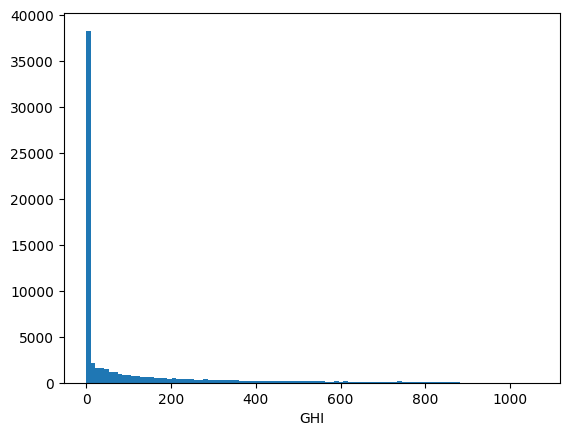

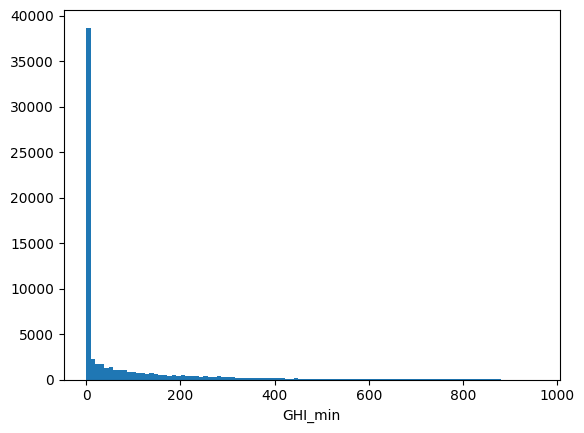

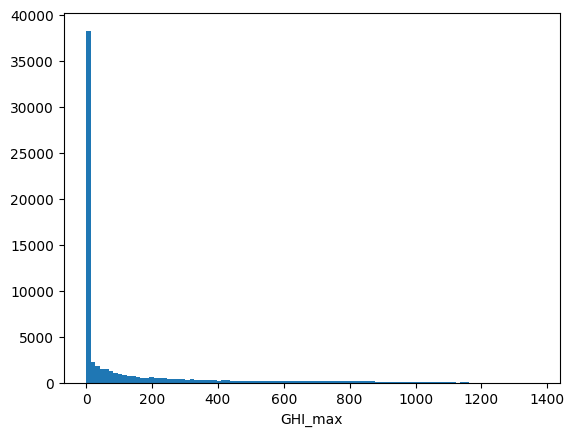

In [31]:
_ = hres_slice.GHI.plot.hist(bins=100)
plt.figure()
_ = hres_slice.GHI_min.plot.hist(bins=100)
plt.figure()
_ = hres_slice.GHI_max.plot.hist(bins=100)
